# Two-photon absorption (TPA) and free-carrier absorption (FCA) in a Si waveguide

In this notebook, we will reproduce part of the experimental results in `Rong, H., Liu, A., Jones, R. et al. An all-silicon Raman laser. Nature 433, 292–294 (2005)` [DOI: 10.1038/nature03273](https://doi.org/10.1038/nature03273). Specifically, the authors provided experimental results for the input-output power relationship for a 4.8cm long rib waveguide, with the output power following a non-linear dependence on the input power due to two-photon absorption (TPA) and free-carrier absorption (FCA) effects. All of the physical parameters are provided in the paper which makes for a great benchmark to reproduce with the first-principle TPA and FCA support in the Tidy3D solver.

<img src="img/TPA_FCA.png" width="400" alt="Schematic of the TPA and FCA in a silicon waveguide">

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
from tidy3d import web

First, define some fundamental parameters as they appear in the paper. It also provides the nonlinear parameters like the TPA coefficient and the FCA optical cross-section. The carrier lifetime $\tau$ on the other hand is controlled by placing the waveguide in a p-i-n junction and controlling the voltage across the junction, which can help sweep out free carriers faster. We are going to model three different carrier lifetimes, as presented in Fig. 2 of the [paper](https://doi.org/10.1038/nature03273). The paper also reports a linear waveguide loss of 0.35 dB/cm. We will account for it by adding an imaginary part of the  permittivity, or equivalently, a finite conductivity to the silicon medium.

In [2]:
wavelength = 1.55  # wavelength of interest
freq0 = td.C_0 / wavelength  # corresponding frequency

wg_w = 1.5  # rib waveguide width
wg_h = 0.7  # rib waveguide height
si_h = 0.85  # silicon slab thickness
wg_l = 4.8e4  # wavelength length (4.8 cm)

si_n0 = 3.47  # refractive index of silicon
si_cond = 7.4e-5  # conductivity in S / um of silicon to account for the linear loss
tpa_beta = 0.5e-5  # TPA coefficient in um / W
fca_sigma = 1.47e-9  # FCA cross-section in um**(-2)

The TPA + FCA modeling in Tidy3D follows these equations:

$$
\begin{align}
    P_{NL} &= P_{TPA} + P_{FCA} + P_{FCPD}, \\
    P_{TPA} &= -\frac{4}{3}\frac{c_0^2 \varepsilon_0^2 n_0^2 \beta}{2 i \omega} |E|^2 E, \\
    P_{FCA} &= -\frac{c_0 \varepsilon_0 n_0 \sigma N_f}{i \omega} E, \\
    \frac{dN_f}{dt} &= \frac{8}{3}\frac{c_0^2 \varepsilon_0^2 n_0^2 \beta}{8 q_e \hbar \omega} |E|^4 - \frac{N_f}{\tau}, \\
    N_e &= N_h = N_f, \\
    P_{FCPD} &= \varepsilon_0 2 n_0 \Delta n (N_f) E, \\
    \Delta n (N_f) &= (c_e N_e^{e_e} + c_h N_h^{e_h}),
\end{align}
$$

where $P$ denote various polarization densities, and $N_f$ is the free carrier concentration. The factors of $\frac{4}{3}$ and $\frac{8}{3}$ in the equations are coming from using real fields instead of complex fields in the solver. More details can be found on this [study](https://ieeexplore.ieee.org/document/4299014).

We will be looking at continuous-wave operation, in which we evolve the system under a continuous-wave source until a steady state is reached both for the optical oscillations and the free-carrier distribution. In that regime, $\frac{dN_f}{dt} = 0$, and

$$
N_f = \frac{1}{\tau}\frac{8}{3}\frac{c_0^2 \varepsilon_0^2 n_0^2 \beta}{8 q_e \hbar \omega} |E|^4
$$

This means that the free-carrier polarization density $P_{FCA}$ is proportional to $\sigma / \tau$, which allows us to make a simplifying adjustment to be able to run the FDTD simulation within a reasonable number of time steps. Namely, the typical $\tau$ in that system is on the order of nanoseconds, which is much larger than the optical period, and too long for the FDTD simulation. However, we can simultaneously decrease $\tau$ by a factor and increase $\sigma$ by the same factor, such that the steady-state concentration remains the same.

For this illustration, we also will not be simulating the whole 4.8cm waveguide from the paper. We can scale the TPA coefficient $\beta$, making the overall nonlinearity stronger, while correspondingly shortening the waveguide. This is a valid modification to the setup since both the two-photon absorption, and the free-carrier concentration $N_f$, and thus the free-carrier absorption, are proportional to $\beta$.

In [3]:
# make the tau shorter by increasing sigma
tau_scale_factor = 1e-6  # characteristic tau will be femtoseconds instead of nanoseconds

# make the waveguide shorter by increasing beta
beta_scale_factor = 1e3

Now we can define a function to generate the simulation. Note that we will not be including the doped silicon regions and the electrodes, as the authors say that they have verified that their introduction does not affect the light propagation in the linear regime.

In [4]:
def make_sim(
    tpa: bool = True,
    input_power: float = 1.0,
    fca_tau: float = 1.2e-9,  # seconds
):
    # reduce the total waveguide length and correspondingly increase the TPA strength
    wg_l_scaled = wg_l / beta_scale_factor

    if tpa:
        # define TPA specification
        # reduce the FCA tau and correspondingly increase the cross-section
        tpa_material = td.TwoPhotonAbsorption(
            beta=tpa_beta * beta_scale_factor,
            tau=fca_tau * tau_scale_factor,
            sigma=fca_sigma / tau_scale_factor,
        )

        # define silicon medium
        si = td.Medium(
            permittivity=si_n0**2,
            conductivity=si_cond,
            nonlinear_spec=td.NonlinearSpec(models=[tpa_material], num_iters=5),
        )
    else:
        si = td.Medium(
            permittivity=si_n0**2,
            conductivity=si_cond,
        )

    mat_sio2 = td.Medium(permittivity=1.44**2)  # define oxide medium

    # define the rib waveguide
    rib = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=[-wg_l_scaled - 10, -wg_w / 2, 0], rmax=[wg_l_scaled + 10, wg_w / 2, wg_h]
        ),
        medium=si,
    )

    # define the silicon slab
    slab = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=[-wg_l_scaled - 10, -100, -si_h], rmax=[wg_l_scaled + 10, 100, 0]
        ),
        medium=si,
    )

    # define the BOX layer
    box = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=[-wg_l_scaled - 10, -100, -100], rmax=[wg_l_scaled + 10, 100, -si_h]
        ),
        medium=mat_sio2,
    )

    # define a mode source
    source = td.ModeSource(
        center=(-wg_l_scaled / 2, 0, 0),
        size=(0, 4, 4),
        mode_spec=td.ModeSpec(),
        source_time=td.ContinuousWave(
            freq0=freq0, fwidth=freq0 / 20, amplitude=np.sqrt(input_power)
        ),  # use continuous wave
        direction="+",
    )

    # define a flux time monitor
    flux_time = td.FluxTimeMonitor(
        center=(wg_l_scaled / 2, 0, 0),
        size=(0, 4, 4),
        name="flux_time",
        interval=1,
    )

    # define a auxiliary field time monitor to check the auxiliary field which is related to the nonlinear polarizations
    aux_field = td.AuxFieldTimeMonitor(
        center=flux_time.center, size=(0, 0, 0), fields=["Nfy"], interval=2, name="aux_field"
    )

    # define a simulation
    sim = td.Simulation(
        size=(wg_l_scaled + 2, 5, 5),
        structures=[box, slab, rib],
        monitors=[flux_time, aux_field],
        sources=[source],
        run_time=2e-12,
        normalize_index=None,
    )

    return sim

We can examine the simulation and the time signal of the CW source. Note: the simulation axes do not have the physical aspect ratio as the simulation is very long along x.

11:53:09 CEST WARNING: Monitor: 'aux_field' (simulation.monitors[1]) stores     
              field 'Nfy', which is not used by any of the nonlinear models     
              present in the mediums in the simulation. The resulting data will 
              be zero.                                                          

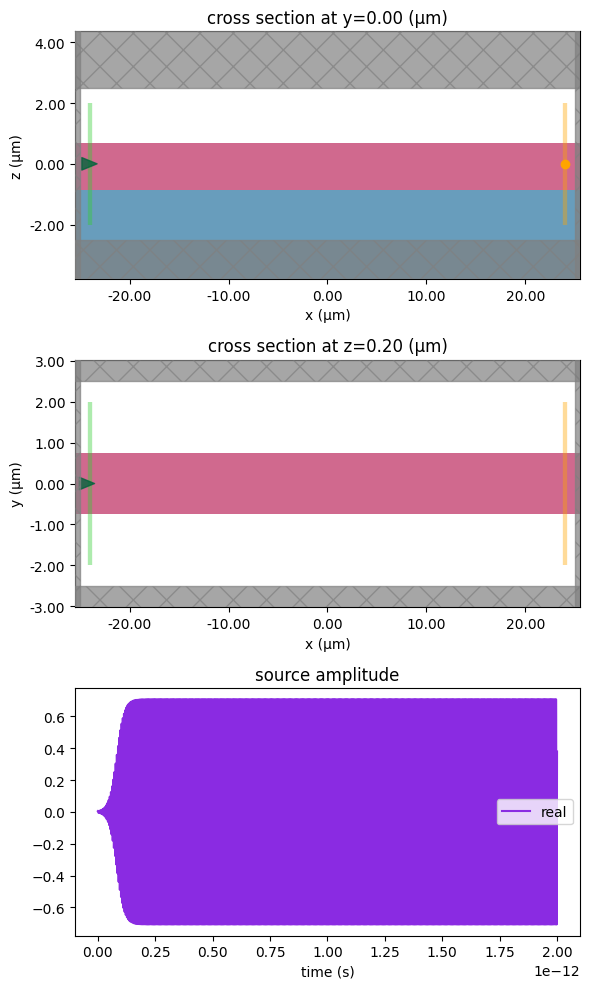

In [5]:
sim = make_sim(tpa=False, input_power=0.5)

fig, ax = plt.subplots(3, 1, figsize=(6, 10), tight_layout=True)
sim.plot(y=0, ax=ax[0])
ax[0].set_aspect("auto")
sim.plot(z=0.2, ax=ax[1])
ax[1].set_aspect("auto")
sim.sources[0].source_time.plot(times=sim.tmesh, ax=ax[2])
plt.show()

We will first examine the waveguide mode to make sure we have what we expect.

11:53:11 CEST Created task 'wg_modes' with task_id                              
              'mos-662a9f6c-8bc6-415c-9377-4a8558c3e91f' and task_type 'MODE'.

Output()

11:53:14 CEST Maximum FlexCredit cost: 0.004. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

11:53:15 CEST status = success

Output()

11:53:18 CEST loading simulation from simulation_data.hdf5

wavelength    n eff     k eff  loss (dB/cm)  \
f            mode_index                                                
1.934145e+14 0                 1.55  3.41443  0.001004    353.415992   

                         TE (Ey) fraction  wg TE fraction  wg TM fraction  \
f            mode_index                                                     
1.934145e+14 0                   0.999346         0.98887        0.981245   

                         mode area  
f            mode_index             
1.934145e+14 0            1.627082

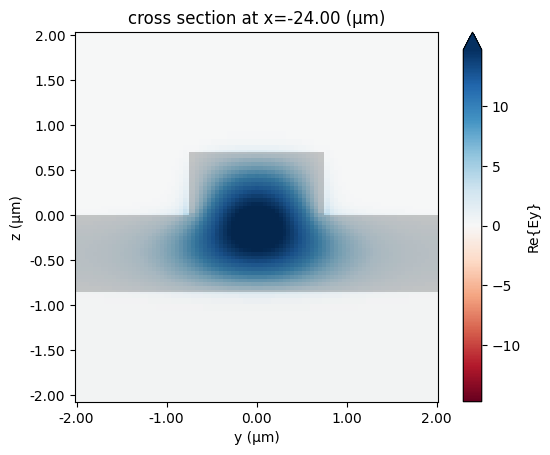

In [6]:
ms = td.ModeSimulation(
    center=sim.center,
    size=sim.size,
    structures=sim.structures,
    plane=sim.sources[0],
    freqs=[freq0],
    mode_spec=td.ModeSpec(),
)

mode_data = web.run(ms, task_name="wg_modes")

fig, ax = plt.subplots(1, 1)
mode_data.plot_field(field_name="Ey", ax=ax)
mode_data.modes.to_dataframe()

Indeed the mode looks like the fundamental waveguide mode, and the mode area of ~1.6 μm$^2$ matches the value given in the paper. Since we shortened the waveguide by a factor of 1000, we need to amplify the linear loss by the same factor to account for it. Here the loss of ~350 dB/cm is what we expect (0.35 dB/cm x 1000).

Now we will run FDTD simulations with three different values for the carrier lifetime, over an array of input powers.

In [7]:
taus = [65e-9, 10e-9, 1.2e-9]  # carrier life time in seconds
powers = [0.01] + np.arange(0.1, 1.1, 0.1).tolist()  # power in watts

sim_dict = {}
for itau, tau in enumerate(taus):
    for ipower, power in enumerate(powers):
        sim = make_sim(fca_tau=tau, input_power=power)
        sim_dict[f"tau{itau}_power{ipower}"] = sim

In [8]:
batch = web.Batch(simulations=sim_dict)
batch_data = batch.run()

Output()

11:53:30 CEST Started working on Batch containing 33 tasks.

11:54:02 CEST Maximum FlexCredit cost: 7.367 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

11:54:27 CEST Batch complete.

Output()

We can examine the flux-time dependence of the longest-lifetime simulation at the highest input power.

11:55:00 CEST WARNING: Simulation final field decay value of 0.983 is greater   
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

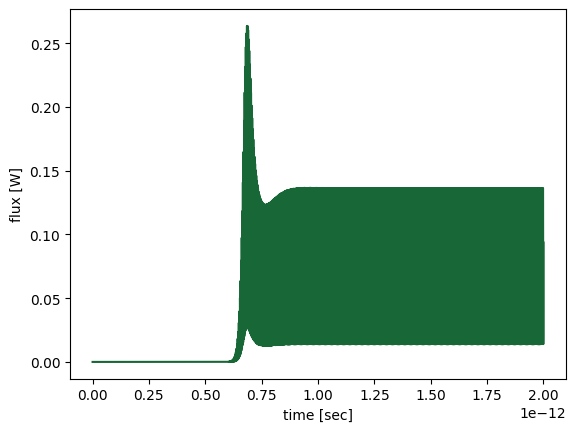

In [9]:
sim_data = batch_data["tau0_power8"]
sim_data["flux_time"].flux.plot()
plt.show()

Similarly we can plot the auxiliary field profile, which is related to the nonlinear polarizations, and see if it has reached steady state. Here we plot `Nfy` since the dominant field is in the $y$ direction. Different components don't interact nonlinearly as a modeling approximation

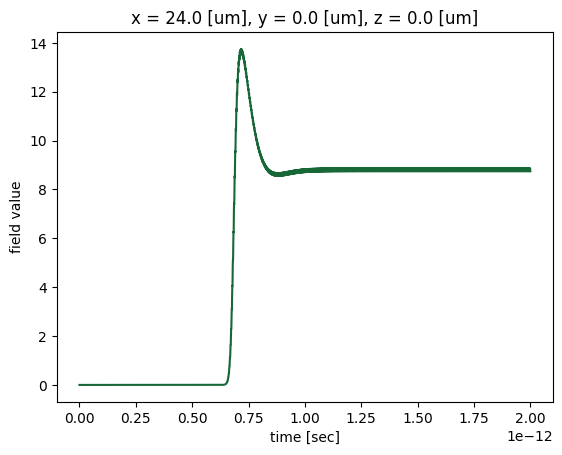

In [10]:
sim_data["aux_field"].Nfy.plot()
plt.show()

The output power is just the time-average of the time-dependent flux once steady-state is reached.

In [11]:
ts = sim.tmesh > 1.5e-12
power = np.mean(sim_data["flux_time"].flux[ts]).values
print("CW flux at output: ", power)

CW flux at output:  0.07502077


Here we turn off the warnings by setting the logging level to `"ERROR"`. This is to prevent many repeated warnings generated from the parameter sweep. In this case, we will get warnings about the field decay not meeting the shutoff condition. Since we inject a CW source, the field will never decay so this is expected. In general, however, we highly advise against turning the warnings off since they can indicate real issues regarding the simulation setup.

In [12]:
from tidy3d.log import set_logging_level

set_logging_level("ERROR")

Now we can compute this output power for all values of $\tau$ and the input power, and recreate Fig. 2 from the [paper](https://doi.org/10.1038/nature03273). The simulation results here closely match the experimental measurements.

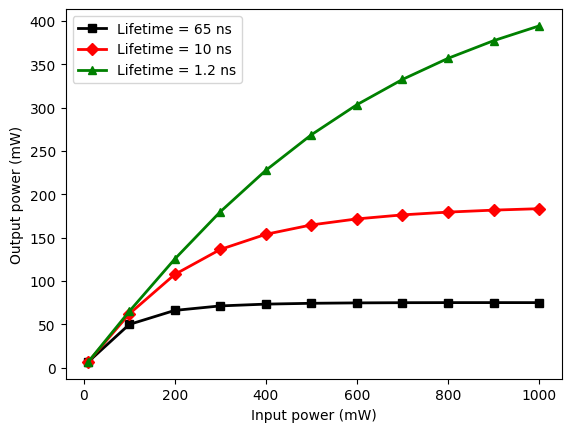

In [13]:
fig, ax = plt.subplots(1)

# colors and markers for styling the plot
colors = ["black", "red", "green"]
markers = ["s", "D", "^"]

# result plotting
for itau, tau in enumerate(taus):
    output_powers = []
    for ipower, power in enumerate(powers):
        output_powers.append(
            np.mean(batch_data[f"tau{itau}_power{ipower}"]["flux_time"].flux[ts]).values
        )
    ax.plot(
        np.array(powers) * 1000,
        np.array(output_powers) * 1000,
        marker=markers[itau],
        markersize=6,
        label=f"Lifetime = {tau * 1e9:.2g} ns",
        c=colors[itau],
        linewidth=2,
    )

ax.legend()
ax.set_xlabel("Input power (mW)")
ax.set_ylabel("Output power (mW)")
plt.show()